# Effective Large File for Image Analysis (E.L.F.I.A)
Designed by Hao Wang $$ $$
Version 5.1 --last update 2023-Feb-10$$ $$
Email harrywang11@126.com for any problem

In [1]:
# certain environments are needed *need info
import argparse
import glob
import os
import cv2
import csv
import ntpath
import pickle

import networkx as nx
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from skimage import transform, morphology, filters
from scipy import ndimage as ndi
 
from scipy.ndimage import gaussian_filter
from skimage import exposure, img_as_float, img_as_ubyte, measure
from skimage.filters import threshold_li
from skimage.morphology import white_tophat, black_tophat, disk, reconstruction, opening, closing, dilation, skeletonize
from skimage.segmentation import random_walker
from skimage import io

from matplotlib.patches import Ellipse
from scipy import stats

import ntpath
import warnings

from PIL import Image
from skimage import img_as_uint, transform
import sknw

import tkinter as tk
from skan import skeleton_to_csgraph  # pip install skan
from skan import Skeleton, summarize
import winsound

[[108 108 109 ... 108 108 109]
 [108 108 109 ... 109 108 108]
 [109 108 109 ... 109 109 108]
 ...
 [109 108 109 ... 109 110 109]
 [109 108 109 ... 109 110 109]
 [109 108 109 ... 110 110 111]]


True

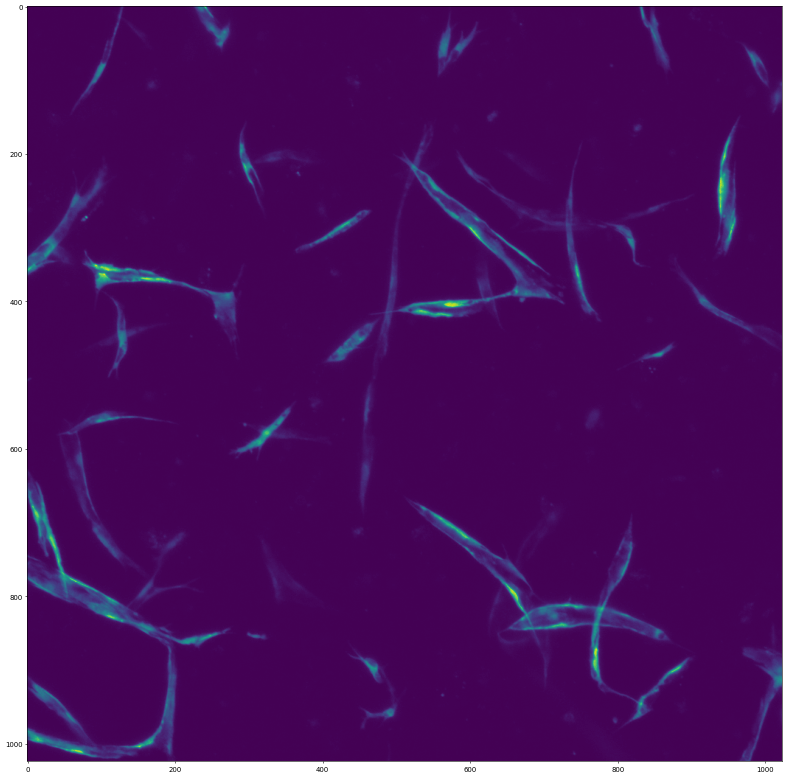

In [2]:
# can run independently
# add all layers
from PIL import Image
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
# read img
img = io.imread(r'C:\Users\Harry\OneDrive\UNC\Research\William Polacheck\Data\20210326_gfpcontrol_pf_zerohour\20210326_gfpcontrol_pf0h_120h_well1.tif')    # change file name here
x=img

# for multi-layers

#x=np.array(img[0])
#for i in range(1,len(img)):          # change here to select layers
    #x=x+img[i]
# get single layer
#layer = 35 # individual graph
#thers = 18
#thisl = x>thers
#x=x/70

#scale to 8 bits
scale = np.amax(x)
y = x/scale
y=y*256
int_x = y. astype(int)
# show image
fig = plt.figure(figsize=(20, 20), dpi=50)
plt.imshow(int_x)
print(int_x)
# need to be tested
unper_bound = np.quantile(int_x,0.99)
# export image as png
cv2.imwrite('t3.png', int_x)

In [3]:
#Process the image
import cv2
# read original image
image = cv2.imread("t3.png")
# convet to gray scale image
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
cv2.imwrite('gray.png', gray)

# apply median filter for smoothning
blurM = cv2.medianBlur(gray, 5)
cv2.imwrite('blurM.png', blurM)

# apply gaussian filter for smoothning
blurG = cv2.GaussianBlur(gray, (9, 9), 0)
cv2.imwrite('blurG.png', blurG)
  
# histogram equalization
histoNorm = cv2.equalizeHist(gray)
cv2.imwrite('histoNorm.png', histoNorm)

# create a CLAHE object for 
# Contrast Limited Adaptive Histogram Equalization (CLAHE) 
clahe = cv2.createCLAHE(clipLimit = 2.0, tileGridSize=(8, 8))
claheNorm = clahe. apply(gray)
cv2.imwrite('claheNorm.png', claheNorm)

True

In [4]:
# contrast stretching 
# Function to map each intensity level to output intensity level. 
def pixelVal(pix, r1, s1, r2, s2):
    if (0 <= pix and pix <= r1):
        return (s1 / r1) * pix
    elif (r1 < pix and pix <= r2):
        return ((s2 - s1) / (r2 - r1)) * (pix - r1) + s1
    else:
        return ((255 - s2) / (255 - r2)) * (pix - r2) + s2
  
    # Define parameters. 
  
  
r1 = 70  #key parameter lager the more
s1 = 0
r2 = 100
s2 = 255

area fraction= 0.18886470794677734


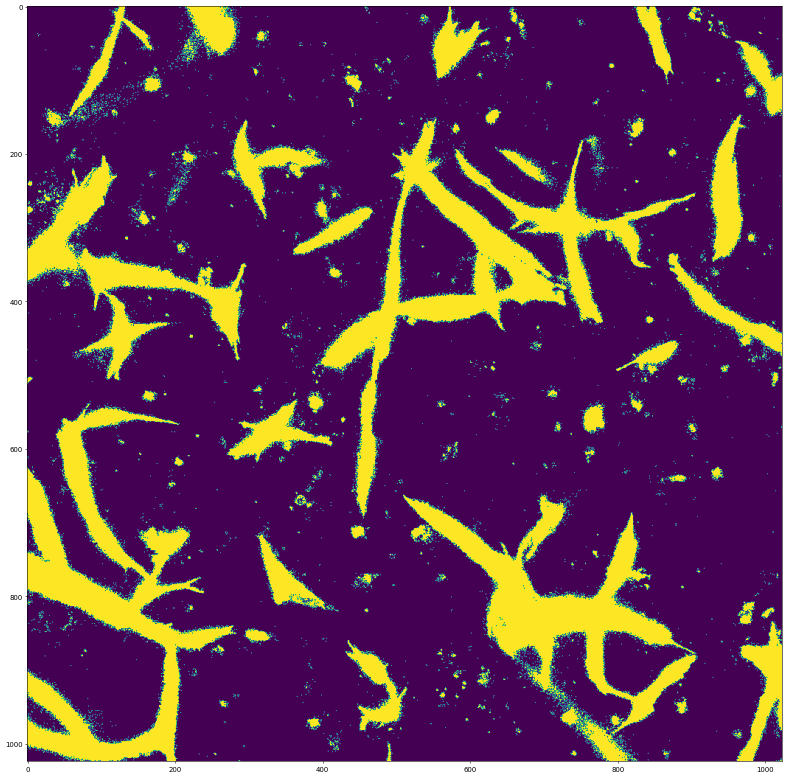

In [7]:
# clean step 1
# Vectorize the function to apply it to each value in the Numpy array. 
pixelVal_vec = np.vectorize(pixelVal)
  
# Apply contrast stretching. 
contrast_stretched = pixelVal_vec(gray, r1, s1, r2, s2)
contrast_stretched_blurM = pixelVal_vec(blurM, r1, s1, r2, s2)
  
cv2.imwrite('contrast_stretch.png', contrast_stretched)
cv2.imwrite('contrast_stretch_blurM.png', 
            contrast_stretched_blurM)
# first parameter matters
his_stre =  pixelVal_vec(histoNorm, 200, 0, 100, 255) 
# edge detection using canny edge detector

#edgeH = cv2.Canny(his_stre, 100, 100)
fig = plt.figure(figsize=(20, 20), dpi=50)
#plt.imshow(his_stre)
data = 255 * his_stre # Now scale by 255
img1 = data.astype(np.uint8)

# convert to binary graph
img1[img1>0]=1
#print(img1)
#plt.imshow(his_stre)

# show result
plt.imshow(img1)
num = np.count_nonzero(img1)
total = np.shape(img1)[0]*np.shape(img1)[1]

# use this for area fraction
areaf = str(num/total)
areafrac = 'area fraction= '+areaf
print(areafrac)

area fraction= 0.1582479476928711


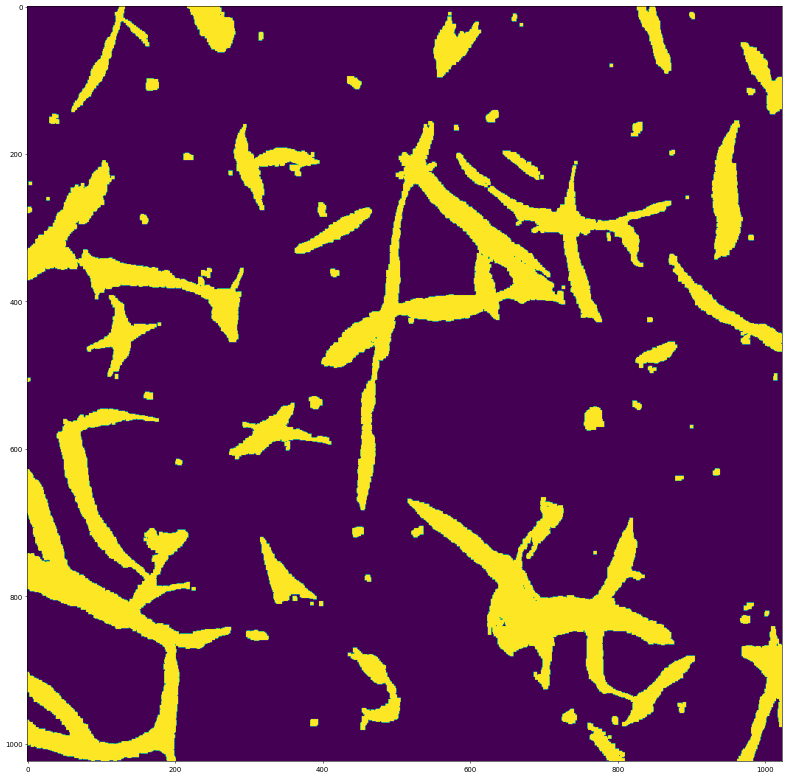

In [8]:
# clean step 2
# Filter using contour area and remove small noise
ret, thresh = cv2.threshold(img1, 0, 255, cv2.THRESH_BINARY)
kernel = np.ones((5, 5), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
cleaned = morphology.remove_small_objects(opening, min_size=2000, connectivity=1)
# show result
fig = plt.figure(figsize=(20, 20), dpi=50)
plt.imshow(cleaned)
num = np.count_nonzero(cleaned)
# only as a reference
total = np.shape(cleaned)[0]*np.shape(cleaned)[1]
print('area fraction=', num/total)

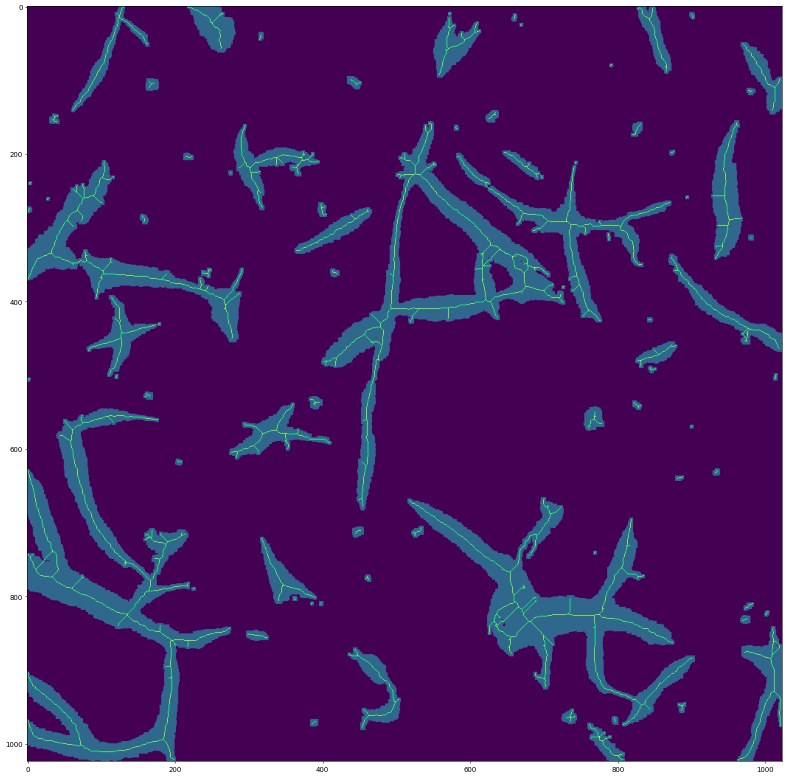

In [9]:
# binary graph
cleaned[cleaned>0] = 1
fig = plt.figure(figsize=(20, 20), dpi=50)
#plt.imshow(close)
# create skeleton
skeleton = skeletonize(cleaned)
#plot skeleton on original image
res = np.zeros((len(cleaned),len(cleaned[0])))
res[skeleton]=2
res = res+cleaned
plt.imshow(res)

area fraction= 0.7706336975097656


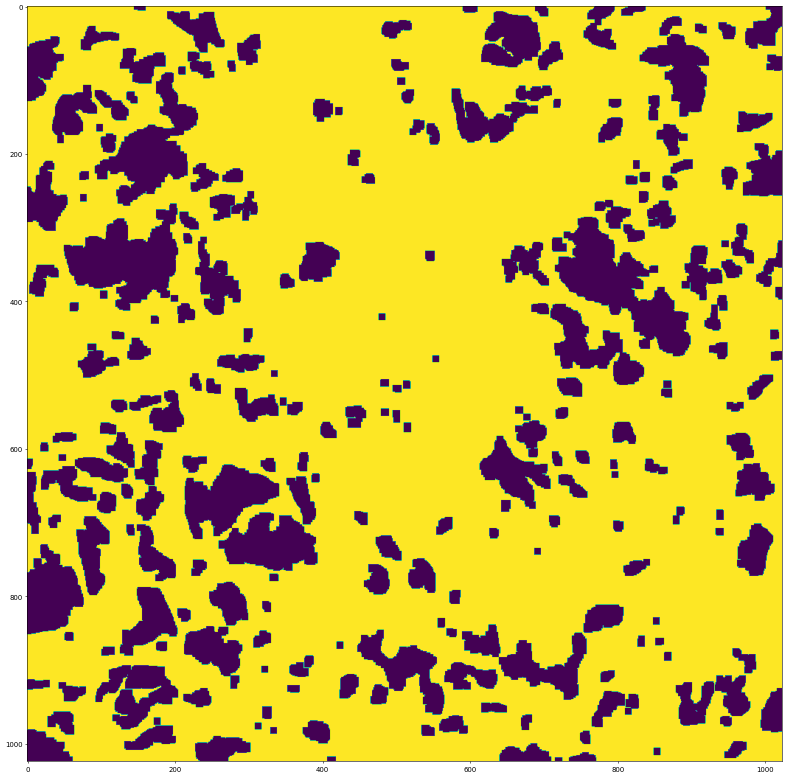

In [326]:
# clean step 3
# use this for more connected view
cnts = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    area = cv2.contourArea(c)
    if area < 5500:  # modify this parameter
        cv2.drawContours(thresh, [c], -1, (0,0,0), -1)

# Morph close and invert image
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
close = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2)
# show result
fig = plt.figure(figsize=(20, 20), dpi=50)
plt.imshow(close)
num = np.count_nonzero(close)
total = np.shape(close)[0]*np.shape(close)[1]
print('area fraction=', num/total)

area fraction= 0.6644935607910156


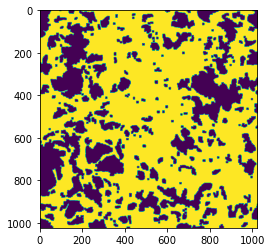

In [327]:
# directlt use this may cause problems
# a moderate cleanning compared to last step
import cv2
from celluloid import Camera
from PIL import Image
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from skimage import exposure, img_as_float, img_as_ubyte, measure
from skimage.filters import threshold_li
from skimage.morphology import white_tophat, black_tophat, disk, reconstruction, opening, closing, dilation, skeletonize
from skimage.segmentation import random_walker

cnts = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    area = cv2.contourArea(c)
    if area < 5500:
        cv2.drawContours(thresh, [c], -1, (0,0,0), -1)

# Morph close and invert image 
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
close = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2)
# convert to binary graph
close[close>0] = 1
plt.imshow(close)
num = np.count_nonzero(close)
total = np.shape(close)[0]*np.shape(close)[1]

areaf2 = str(num/total)
areafrac2 = 'area fraction= '+areaf2
print(areafrac2)

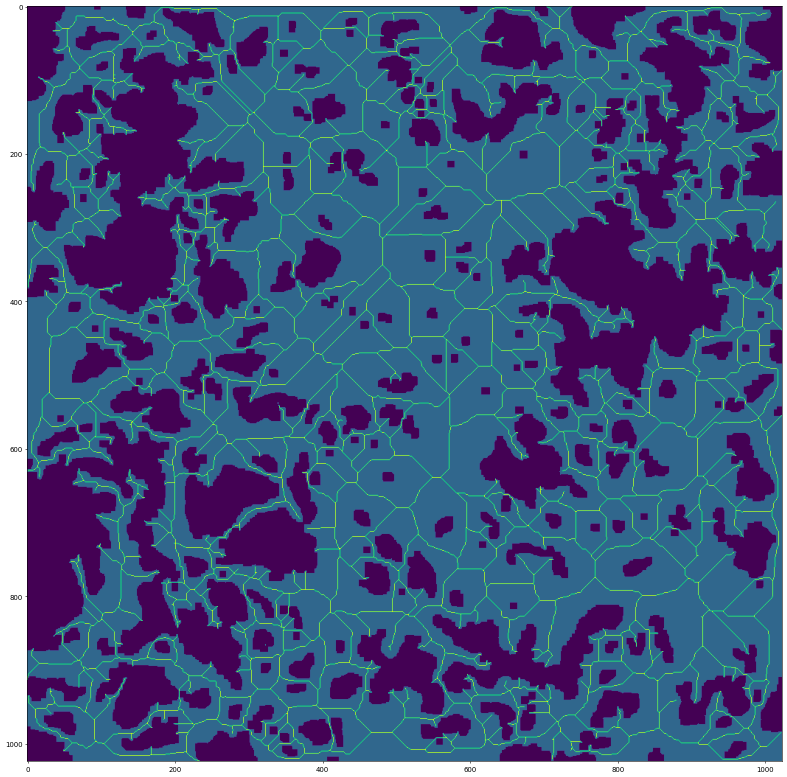

In [328]:
# create skeleton based on last step
close[close>0] = 1
fig = plt.figure(figsize=(20, 20), dpi=50)
#plt.imshow(close)
skeleton = skeletonize(close)
# use this for result
res = np.zeros((len(skeleton),len(skeleton[0])))
res[skeleton]=2
res = res+close
plt.imshow(res)

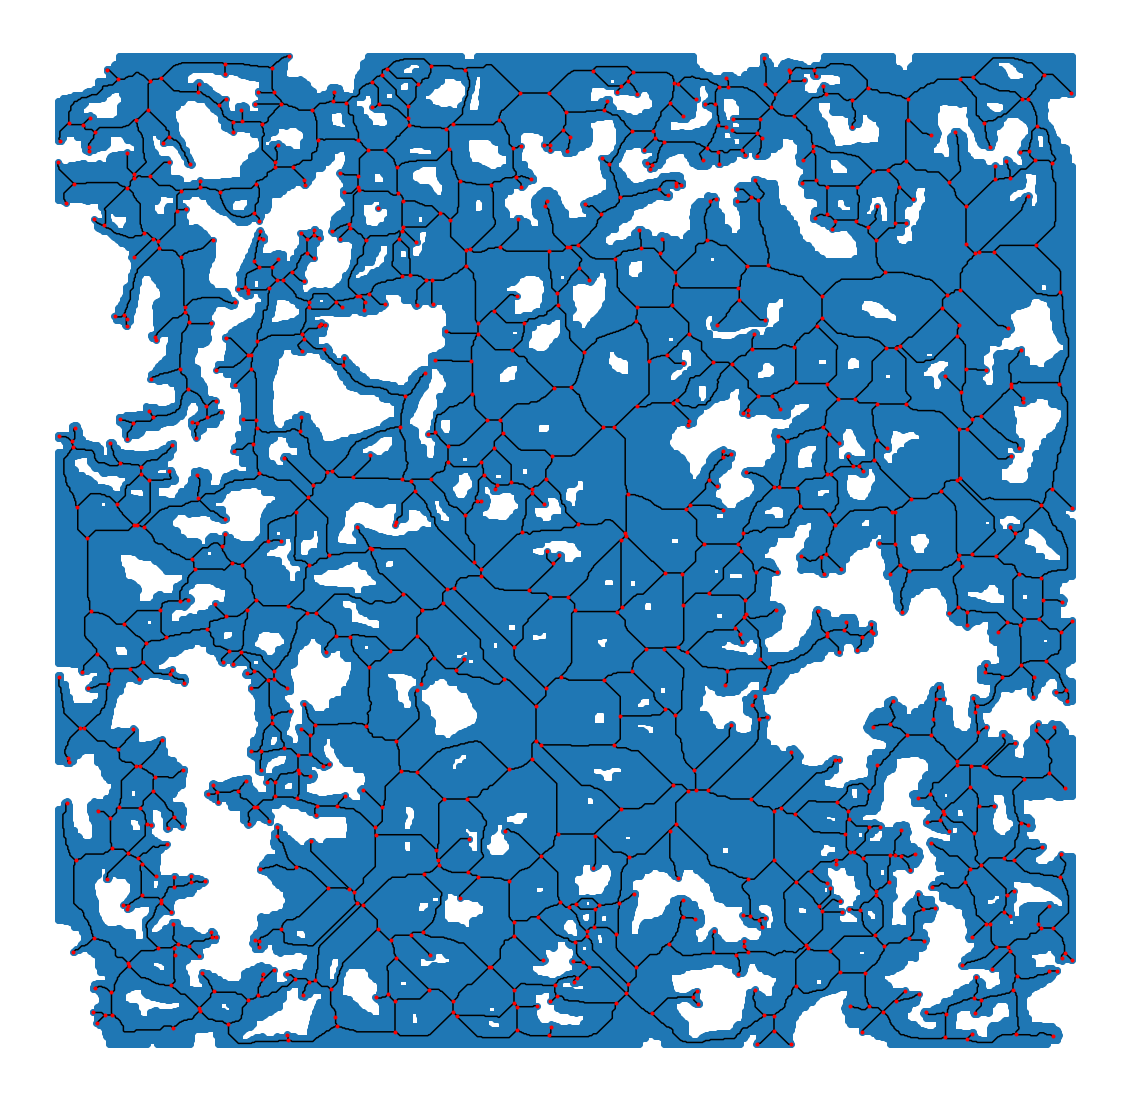

In [329]:
#pip install sknw
# create nodes (may take a while)
import sknw
fig = plt.figure(figsize=(20,20))
graph = sknw.build_sknw(skeleton)
for (s,e) in graph.edges():
    ps = graph[s][e]['pts']
    plt.plot(ps[:,1], ps[:,0], 'black')
xlist=[]
ylist=[]
# for 3D
#ylen = img.shape[1]
#zlen = img.shape[2]

# for 2D
ylen = img.shape[0]
zlen = img.shape[1]
map1 = np.arange(ylen*zlen)
map2 = map1.reshape((ylen,zlen))
rest = map2[close>0]
xr = rest%1024
yr = rest//1024
plt.scatter(xr,yr)    
# draw node by o
nodes = graph.nodes()
ps = np.array([nodes[i]['o'] for i in nodes])
plt.plot(ps[:,1], ps[:,0], 'r.')
# remove axis
plt.axis('off')
# title and show
#plt.title('Node Graph')
plt.show()
fig.savefig(fname='node.png',dpi = 500, bbox_inches='tight')

average length 28.1716579977545
average distance 26.081261267543844
Clustering 0.010931416591793953


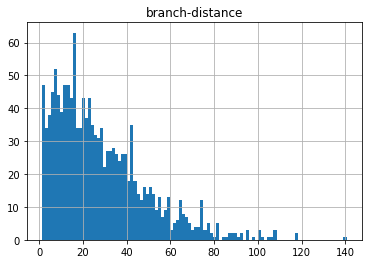

In [330]:
# get number of nodes
# analysis skeleton
from skan import skeleton_to_csgraph  # pip install skan
from skan import Skeleton, summarize

# get average edge length
spacing_nm = 1 #nm per pixel
branch_data = summarize(Skeleton(skeleton, spacing=spacing_nm))
average_edgelen = np.average(branch_data['branch-distance'])
print('average length',average_edgelen)   

# get average euclidean-distance
average_distance = np.average(branch_data['euclidean-distance'])
print('average distance',average_distance) 

#rint(np.count_nonzero(skeleton))

# connectivity?  *usually 1
#node_connectivity=nx.node_connectivity(graph)  #could take a while
#print('Connectivity',node_connectivity)

# clustering
clu_num = nx.clustering(graph)  #fraction of possible triangles
cluster_level =sum(clu_num.values()) / len(clu_num)
print('Clustering',cluster_level )


branch_data.head()
# distribution
branch_data.hist(column='branch-distance', bins=100);

In [331]:
# average radius  created by Harry Wang  5.21.2021 v1.0.0
import matplotlib.pyplot as plt
from skimage import draw
# must be binary graph
def add_circle(x,y,radi,orgi):
    rr, cc = draw.circle(x, y, radius=radi,shape=orgi.shape)
    orgi[rr, cc] = 1
# return the maximum circle that can fit in to the graph
# radi is the best guess to save time 
# about O(1) based on luck
def find_radi(x,y,radi,orgi):
    new_g = np.copy(orgi)
    add_circle(x,y,radi,new_g)
    ct = np.count_nonzero(new_g-orgi)
    correct_radi = radi
    if(ct>0):
        while((ct>0)&(correct_radi>=0)):
            new_g = np.copy(orgi)
            correct_radi = correct_radi-1
            add_circle(x,y,correct_radi,new_g)
            ct = np.count_nonzero(new_g-orgi)
        return correct_radi
    else:
        while((ct==0)&(correct_radi<=200)):
            new_g = np.copy(orgi)
            correct_radi = correct_radi+1
            add_circle(x,y,correct_radi,new_g)
            ct = np.count_nonzero(new_g-orgi)
        return correct_radi -1
    return radi

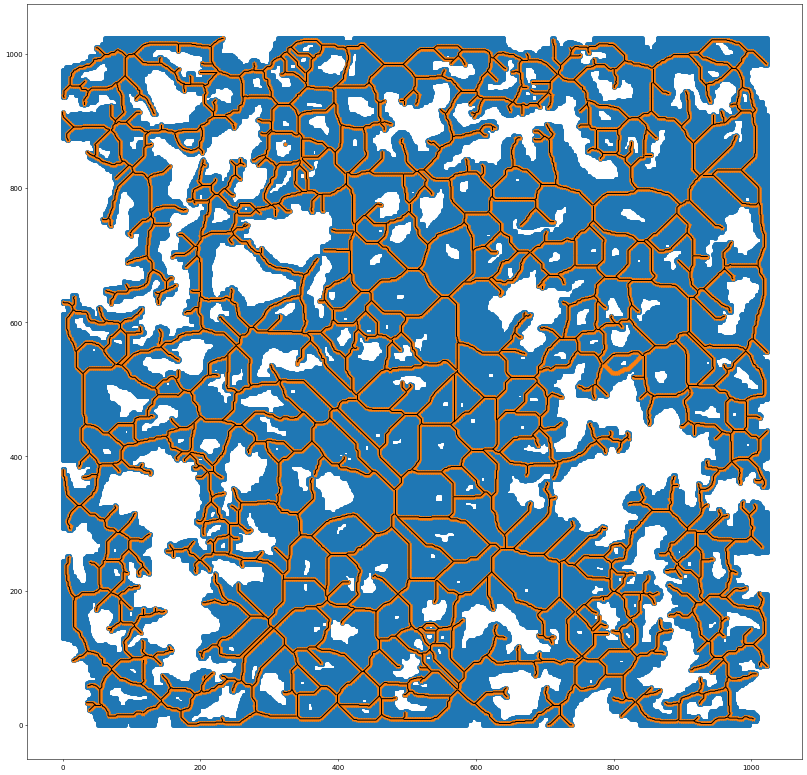

In [332]:
#variable used
#skeleton
#close
#print(np.nonzero(skeleton))
#print(len(np.nonzero(skeleton)[0]))
size_edge = len(np.nonzero(skeleton)[0])

# chose 1000 random points on edges
np.random.seed(10010) # just for test

#selet_size = 1000  #1000 is a reasonable number, too large will casuse more time, too small won't be accurate
selet_size = size_edge # try to run it all to see the difference take less than 30min (2% differen )

# about O(n) for finding the average radius
numbers = np.random.choice(range(size_edge), selet_size, replace=False)
y_d=np.nonzero(skeleton)[0][numbers]
x_d=np.nonzero(skeleton)[1][numbers]
a = close

fig = plt.figure(figsize=(20, 20), dpi=50)
ax = plt.gca()

ylen = img.shape[0]
zlen = img.shape[1]
map1 = np.arange(ylen*zlen)
map2 = map1.reshape((ylen,zlen))
rest = map2[close>0]
xr = rest%1024
yr = rest//1024
plt.scatter(xr,yr) 
for (s,e) in graph.edges():
    ps = graph[s][e]['pts']
    plt.plot(ps[:,1], ps[:,0], 'black')
plt.scatter(x_d,y_d,marker='*')

#for x in range (len(y_d)):
    #circle1 = plt.Circle((x_d[x],y_d[x]),20, color='r')
    #ax.add_patch(circle1)


<ipython-input-331-57c0e37795e2>:6: FutureWarning: circle is deprecated in favor of disk.circle will be removed in version 0.19
  rr, cc = draw.circle(x, y, radius=radi,shape=orgi.shape)


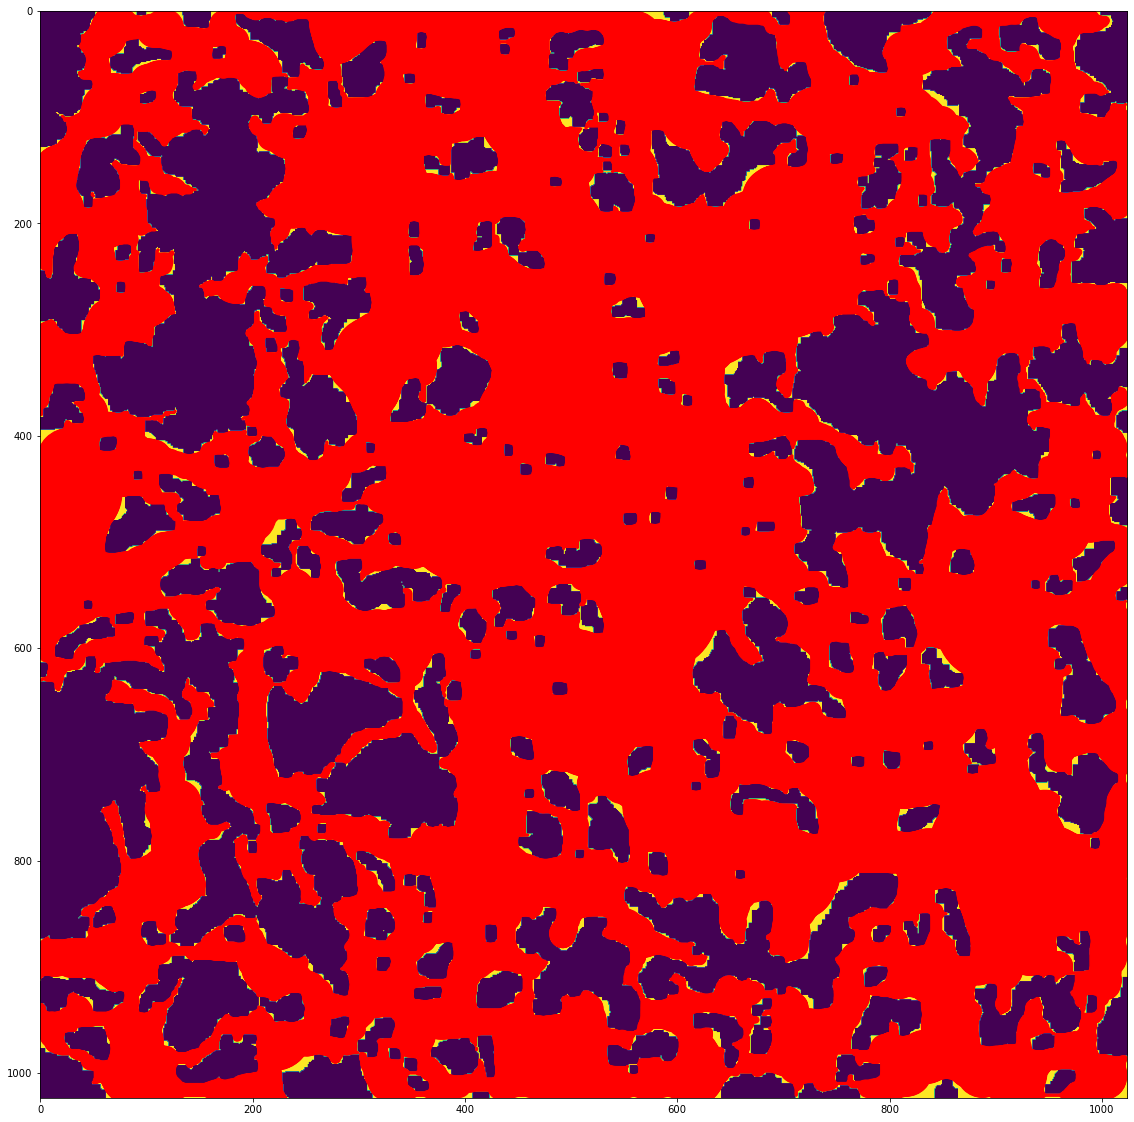

In [333]:
import winsound
# cost about 1min on i7-10700 for 1000 points
fig = plt.figure(figsize=(20,20))
ax = plt.gca()
close[close>0] = 1
plt.imshow(close)
total_radius = 0
list_dots = []
for x in range (len(y_d)):
    radx = find_radi(y_d[x],x_d[x],average_distance/2,close)
    total_radius= total_radius+radx
    circle1 = plt.Circle((x_d[x],y_d[x]),radx, color='r')
    ax.add_patch(circle1)
    list_dots.append(radx)
#plt.invert_yaxis()
average_radi = total_radius/len(y_d)
#print('Average radius (pixel)', average_radi)
#print(list_dots)
# beep when finished
#winsound.Beep(500, 1000)

Average radius (pixel) 14.932096824625972


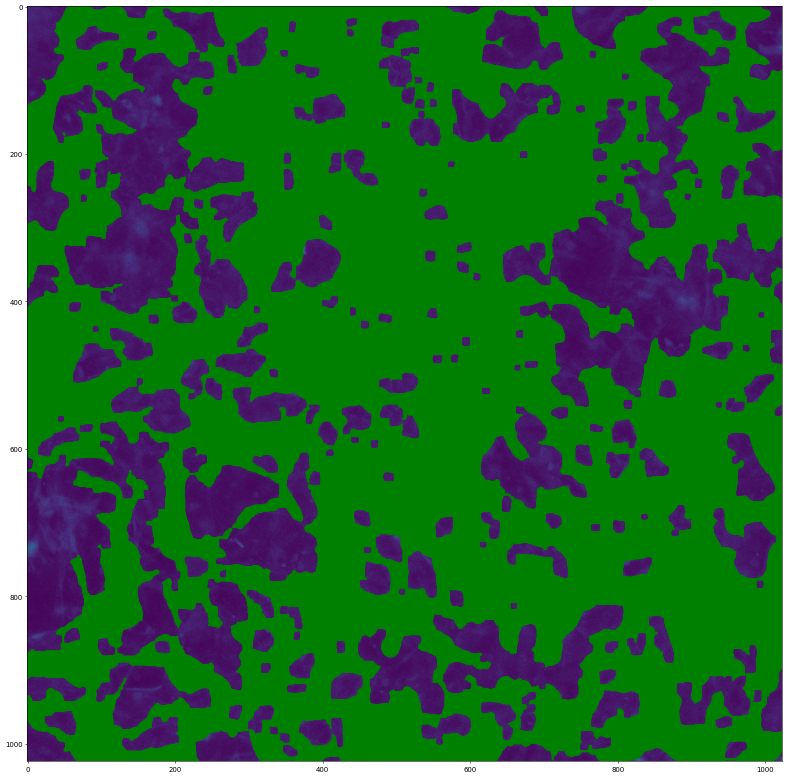

In [334]:
fig = plt.figure(figsize=(20, 20), dpi=50)
plt.imshow(int_x)
print('Average radius (pixel)', average_radi)
ax = plt.gca()
for x in range (len(y_d)):
    circle1 = plt.Circle((x_d[x],y_d[x]),list_dots[x], color='g')
    ax.add_patch(circle1)

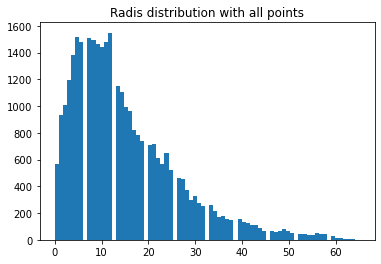

In [335]:
#a = np.histogram(list_dots,bins='auto')
plt.hist(list_dots, bins='auto')
plt.title("Radis distribution with all points")
plt.show()

In [336]:
# the end of program
winsound.Beep(500, 1000)

In [ ]:
# plot two graph together
# take about 1 min, change dpi to go faster
f = plt.figure(figsize=(20, 20), dpi=50)

# plot1
f.add_subplot(2,2, 1)
plt.imshow(int_x)
plt.axis('off')
plt.title('original')
#plot2
f.add_subplot(2,2, 2)
plt.imshow(close)
plt.axis('off')
plt.title(areafrac2)
#plot3
f.add_subplot(2,2, 3)
plt.imshow(res)
plt.axis('off')
plt.title('Skeleton Grap')
#plot4
f.add_subplot(2,2, 4)
plt.imshow(np.flipud(mpimg.imread('node.png')))
plt.axis('off')
plt.title('Node Graph')
plt.show(block=True)
# save fig
# change dpi to lever quality and size
f.savefig(fname='20210117_144h_10x_1_4in1.png',dpi = 1000)

In [ ]:
#GUI 1.0
import skimage
import skimage.feature
import skimage.viewer
import sys
from skimage.viewer.widgets import Slider
from skimage.viewer.widgets.history import SaveButtons
import tkinter as tk
import cv2
from tkinter import * 
from PIL import Image as Img
from PIL import ImageTk
import os

# create folder named cache to store each image in the process
cwd = os.getcwd()
cachedir=cwd+'\\cache'
if not os.path.isdir(cachedir):
    os.mkdir('cache')

window = tk.Tk()
greeting = tk.Label(text="Hello, welcome to ELF 1.0")
frame = tk.Frame()
label = tk.Label(master=frame)

frame_a = tk.Frame(master=window)
label_a = tk.Label(master=frame_a, text="Frame A")
label_a.pack()

frame_b = tk.Frame(master=window)
label_b = tk.Label(master=frame_b, text="Frame B")
label_b.pack()

frame_a.pack(side=tk.TOP)
frame_b.pack(side=tk.BOTTOM)

frame_c = tk.Frame(master=frame_a)
label_c = tk.Label(master=frame_c, text="Frame C")
label_c.pack()

frame_d = tk.Frame(master=frame_a)
label_d = tk.Label(master=frame_d, text="Frame D")
label_d.pack()

frame_c.pack(side=tk.LEFT)
frame_d.pack(side=tk.RIGHT)
#slider
t1 = 70
t2 = 255
sli1 = tk.Scale(frame_b, from_=0, to=255, orient=tk.HORIZONTAL,length=500,variable = t1)
sli1.pack(side=tk.TOP)
sli2 = tk.Scale(frame_b, from_=0, to=255, orient=tk.HORIZONTAL,length=500,variable = t2)
sli2.pack(side=tk.BOTTOM)

label_f = tk.Label(master=frame_b, text='tr')
label_f.pack()

#show image

# read original image
img = io.imread('20210117_96h_10x_1.tif')    # change file name here
f1 = plt.figure(figsize=(20, 20), dpi=50)
x=img
scale = np.amax(x)
y = x/scale
y=y*256
int_x = y.astype(int)
# save first image as t1
name1 = cachedir+'\\t1.png'
cv2.imwrite(name1, int_x)

# save more visual img
plt.imshow(int_x)
plt.axis('off')
plt.title('original')
namex1 = cachedir+'\\img1.png'
f1.savefig(fname=namex1,dpi = 50,bbox_inches='tight')

# read modified img
image = cv2.imread(name1)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
histoNorm = cv2.equalizeHist(gray)
name2 = cachedir+'\\histoNorm.png'
cv2.imwrite(name2, histoNorm)

pixelVal_vec = np.vectorize(pixelVal)
his_stre =  pixelVal_vec(histoNorm, np.quantile(int_x,0.99), 0, 100, 255) 
data = 255 * his_stre # Now scale by 255
img1 = data.astype(np.uint8)
#img1[img1>0]=1
name3 = cachedir+'\\t2.png'
cv2.imwrite(name3, img1)
#plt.imshow(img1)

# save more visual histoNorm
f2 = plt.figure(figsize=(20, 20), dpi=50)
plt.imshow(histoNorm)
plt.axis('off')
plt.title('modified')
namex2 = cachedir+'\\img2.png'
f2.savefig(fname=namex2,dpi = 50,bbox_inches='tight')

# maybe resizing?
ori_1 = Img.open(namex1).resize((400,400), Img.ANTIALIAS)   # resize to 400*400
modi_1 = Img.open(namex2).resize((400,400), Img.ANTIALIAS)
img_ori = ImageTk.PhotoImage(ori_1)
img_modi = ImageTk.PhotoImage(modi_1)

canvas_ori = tk.Canvas(master=frame_c,width = 400, height = 400)
canvas_ori.pack()
canvas_ori.create_image(0,0,image=img_ori,anchor=NW)

canvas_modi = tk.Canvas(master=frame_d,width = 400, height = 400)
canvas_modi.pack()
canvas_modi.create_image(0,0,image=img_modi,anchor=NW)

window.mainloop()


In [ ]:
plt.hist(int_x.flatten(), bins=256,range=(0,256))
plt.show()

In [ ]:
np.quantile(int_x,0.95)